In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize, LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    make_scorer,
    log_loss
)

In [ ]:
# The defaults work surprisingly well, no need to specify these manually:
# N_ITERATIONS = 500
# TOLERANCE = 1e-3

sns.set_style()
sklearn.set_config(enable_metadata_routing=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_FOLDER = "drive/MyDrive/COMP9417/"

# Source distribution, q(X, y)
# Could also examine X_test_1.csv for more info about source distribution q(X)
X = pd.read_csv(DATA_FOLDER + "X_train.csv")
y = pd.read_csv(DATA_FOLDER + "y_train.csv").squeeze()

# le = LabelEncoder()
# y = le.fit_transform(y)

X.shape, y.shape

((10000, 300), (10000,))

In [ ]:
CLASSES = np.unique(y)
N_CLASSES = CLASSES.size

CLASSES, N_CLASSES

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 28)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((7000, 300), (3000, 300), (7000,), (3000,))

In [ ]:
# Target distribution, p(X, y). First 202 X values have corresponding labels, the other 1818 don't
X_shifted = pd.read_csv(DATA_FOLDER + "X_test_2.csv")
X_shifted_labelled = X_shifted.iloc[:202, :]

y_shifted = pd.read_csv(DATA_FOLDER + "y_test_2_reduced.csv").squeeze()
# y_shifted = le.transform(y_shifted)

X_shifted.shape, X_shifted_labelled.shape, y_shifted.shape

((2020, 300), (202, 300), (202,))

In [ ]:
print("Unique values in y_shifted:", np.unique(y_shifted))

print("Classes missing from y_shifted:", np.setdiff1d(y, y_shifted))

Unique values in y_shifted: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 23 24 25 26 27]
Classes missing from y_shifted: [ 0  1 16 22]


In [ ]:
# Log loss, weighted up the number of samples in each class (lower is better)
def weighted_log_loss(y_true, y_pred_proba, sample_weight=None):
    epsilon = 1e-15
    y_pred_proba = np.clip(y_pred_proba, epsilon, 1 - epsilon)
    y_true_ohe = label_binarize(y_true, classes=CLASSES)

    if sample_weight is None:
        # Weight the classes by the inverse frequencies
        class_counts = np.sum(y_true_ohe, axis=0)

        # class_weights = 1/class_counts, weighting classes with no samples as 0
        #   https://stackoverflow.com/a/37977222/21453336
        class_weights = np.divide(
            1.0,
            class_counts,
            out=np.zeros(class_counts.shape, dtype=float),
            where=class_counts!=0
        )

        # Normalise the weights so they sum to 1 (for interpretability)
        class_weights /= np.sum(class_weights)

        # Weight each sample by the class weight of the corresponding true y value
        sample_weight = np.sum(y_true_ohe * class_weights, axis=1)

    # Log probabilities are negative, so the mean is too. Negate so the loss is positive.
    loss = -np.mean(sample_weight * np.sum(y_true_ohe * np.log(y_pred_proba), axis=1))
    return loss

# Negative weighted log loss (higher is better)
neg_wll = make_scorer(
    weighted_log_loss, response_method="predict_proba", greater_is_better=False
).set_score_request(sample_weight=True)

# Baseline logistic regression model (training dataset)

### Exploratory hyperparameter search

In [ ]:
# Basic logistic regression model
logistic = LogisticRegression(
    # max_iter=N_ITERATIONS,
    # multi_class='multinomial',
    # solver='lbfgs',
    # tol=TOLERANCE,
    class_weight="balanced",  # same as weighted log loss (scaled by some factor)
)

# Pipeline setup - logistic regression with l2 regularisation and PCA to speed up training
lr_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("reduce_dim", PCA(0.90)),  # to speed up training
    ("classifier", logistic),
])

params = {
    # Consistently chose C between 1e-3 and 1e-1 when using (-4, 4, 4), narrowed the range
    "classifier__C": np.logspace(-4, 2, 10),
    "classifier__max_iter": [50, 100, 500],
    "classifier__tol": np.logspace(-1, -4, 4),
}

grid = GridSearchCV(
    estimator=lr_pipe,
    param_grid=params,
    scoring=neg_wll,
    error_score="raise", # type: ignore
    cv=StratifiedKFold(n_splits=3), # 2/3rds of data for training, 1/3rd for evaluation
    n_jobs=-1
)
# grid.fit(X_train, y_train)

# print("Best CV weighted log-loss:", abs(grid.best_score_))
# print("Best params:", grid.best_params_)

Using a grid search with a basic logistic regression model (`class_weight="balanced"` and `PCA(0.95)`) over the parameter grid:

```py
params = {
    "classifier__C": np.logspace(-6, 2, 4),
    "classifier__max_iter": np.logspace(2, 3, 4).astype(int), # 100 to 1000
    "classifier__tol": np.logspace(-2, -5, 4),
}
```

yielded the results:

```
Best CV weighted log-loss: 0.006248451062329731
Best params: {'classifier__C': np.float64(0.00046415888336127773), 'classifier__max_iter': np.int64(100), 'classifier__tol': np.float64(0.01)}
```

in around 3 minutes.

Repeating the experiment with more `C` values improved CV weighted log-loss (WLL), even with a lower number of principal components kept (`PCA(0.9), which keeps 90% of variance in X`). We decreased the number of principal components kept for now to increase training speed, as initial tests have shown PCA only results in a minor drop in model performance (see Appendix). Additionally, we found that the optimal `C` value is of the same order of magnitude with or without PCA. Thus, these results are applicable to later tests that omit PCA from the pipeline to increase performance, at the expense of training time.
```py
params = {
    "classifier__C": np.logspace(-4, 2, 10),
    "classifier__max_iter": [50, 100, 500],
    "classifier__tol": np.logspace(-1, -4, 4),
}
```

This resulted in:
```
Best CV weighted log-loss: 0.005364832605923062
Best params: {'classifier__C': np.float64(0.002154434690031882), 'classifier__max_iter': 50, 'classifier__tol': np.float64(0.01)}
```



## More hyperparameter tuning

The default tolerance and max iterations -- 0.0001 and 100, respectively -- seem reasonable so we can omit them from our grid search. However, the default value for `C`, 1.0, is quite far off the optimal values found. 4e-4 or

We will thus use `LogisticRegressionCV` to perform grid search for the value of `C`. By default, it searches 10 `C` values between 1e-4 and 1e4. As training was extremely fast (under a minute), we increased this to 30 values to allow it to more precisely find the optimum.

We also omitted PCA from the pipeline, as the time savings are negligible for this few parameter combinations and the collinearity reduction doesn't seem to improve performance in practice.

In [ ]:
# Pass sample weights to fit and score
# https://scikit-learn.org/stable/metadata_routing.html#usage-examples

scaler = StandardScaler().set_fit_request(sample_weight=False)

lr_cv = LogisticRegressionCV(
    # Cs=30,
    Cs=np.logspace(-5, 2, 30), # type: ignore
    class_weight="balanced",
    scoring=neg_wll,
    cv=3, # 3 folds, using StratifiedKFold
    n_jobs=-1,
).set_fit_request(sample_weight=True)

# Pipeline setup
lr_cv_pipe = Pipeline(steps=[
    ("scaler", scaler),
    ("classifier", lr_cv),
])

lr_cv_pipe.fit(X_train, y_train) #, sample_weight=np.ones(X_train.shape[0]))
print("Best C:", np.median(lr_cv_pipe.named_steps['classifier'].C_))

Best C: 0.004520353656360245


In [ ]:
# Predict on the validation set
y_pred_val = lr_cv_pipe.predict(X_val)
y_proba_val = lr_cv_pipe.predict_proba(X_val)
print("Weighted log-loss on validation set:", weighted_log_loss(y_val, y_proba_val))

Weighted log-loss on validation set: 0.004596770546911202


In [ ]:
from matplotlib.colors import LogNorm

def plot_metrics(y_true, y_pred, title_info: str):
    fig = plt.figure(layout="constrained", figsize=(17, 7))

    fig_left, fig_right = fig.subfigures(1, 2) # (to add spacing, use e.g. wspace=0.1)
    ax1, ax2 = fig_left.subplots(1, 2, sharey=True, width_ratios=[3, 1])

    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report).transpose()

    # Left side: Main metrics heatmap (precision, recall, f1-score)
    sns.heatmap(
        report_df.iloc[:, :-1],
        annot=True,
        cmap="Blues",
        vmin=0,
        vmax=1,
        cbar=False,
        ax=ax1,
    )

    # Middle: Support heatmap (number of samples in each class)
    sns.heatmap(
        report_df.iloc[:, [-1]],
        annot=True,
        cmap="Greens",
        cbar=False,
        ax=ax2,
        fmt=".0f",
        norm=LogNorm(),
    )
    ax2.tick_params(axis='y', which='both', left=False) # turn off major & minor ticks on the left
    fig_left.suptitle("Classification Report")

    # Right side: Confusion matrix
    ax3 = fig_right.subplots()
    cm = confusion_matrix(
        y_true,
        y_pred,
        normalize="true", # normalise over the true conditions (rows)
    )

    cm *= 100 # Scale to percentage (0-100)

    disp = ConfusionMatrixDisplay(cm)

    disp.plot(
        ax=ax3,
        cmap=sns.color_palette("rocket_r", as_cmap=True),
        values_format=".0f",
        text_kw={"fontsize": "small"},
    )

    labels = np.union1d(y_true, y_pred)
    disp.ax_.set_xticklabels(labels)
    disp.ax_.set_yticklabels(labels)

    fig_right.suptitle("Confusion Matrix (Percentages of True Labels)")
    fig.suptitle(f"Model Performance ({title_info})", fontsize="x-large")
    plt.show()

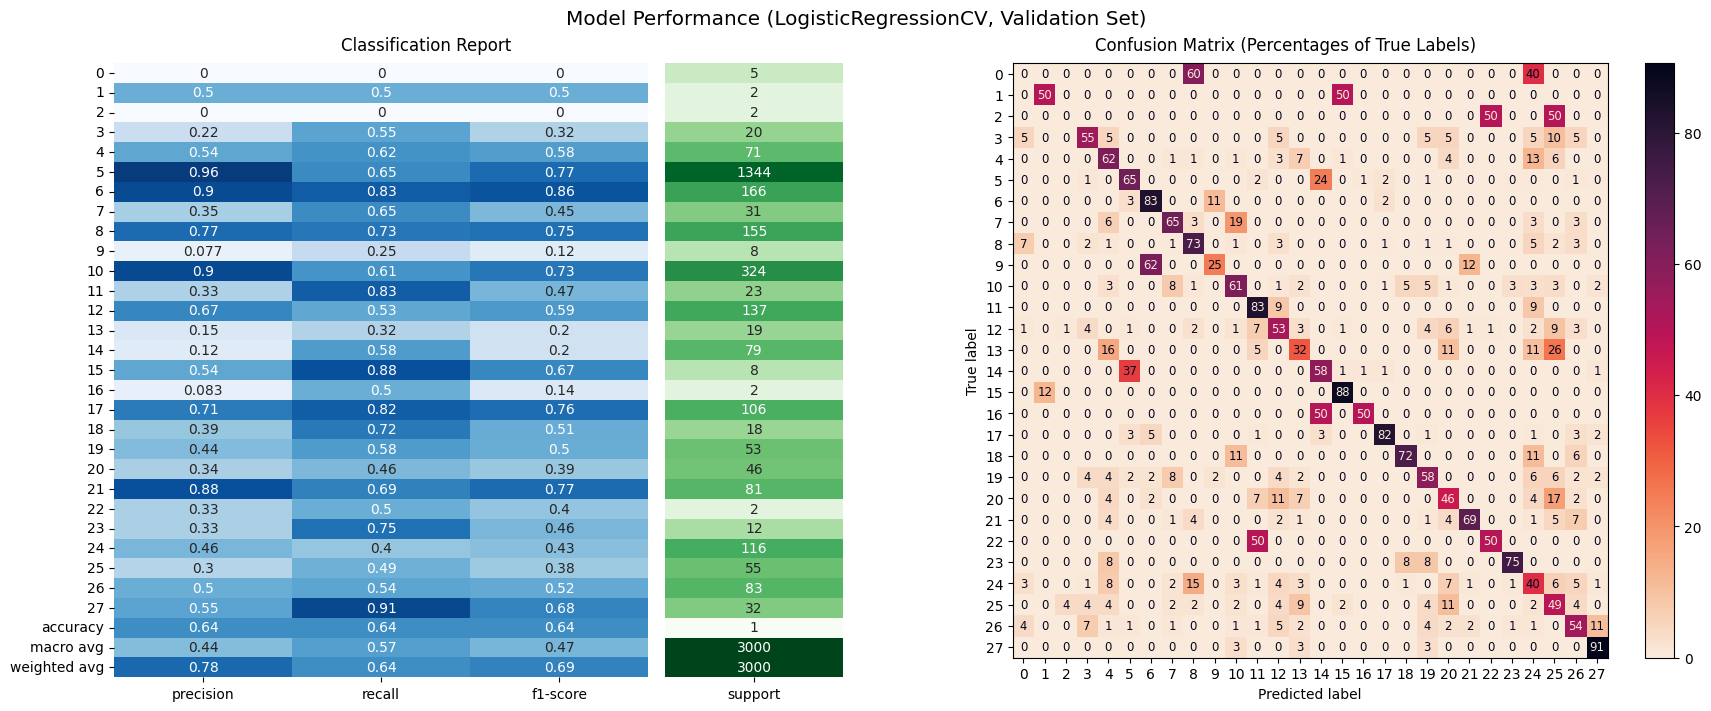

In [ ]:
plot_metrics(y_val, y_pred_val, "LogisticRegressionCV, Validation Set")

## Assess performance on test set 2 (without distribution shift correction)



Weighted log-loss on test set 2: 0.016492161433618122


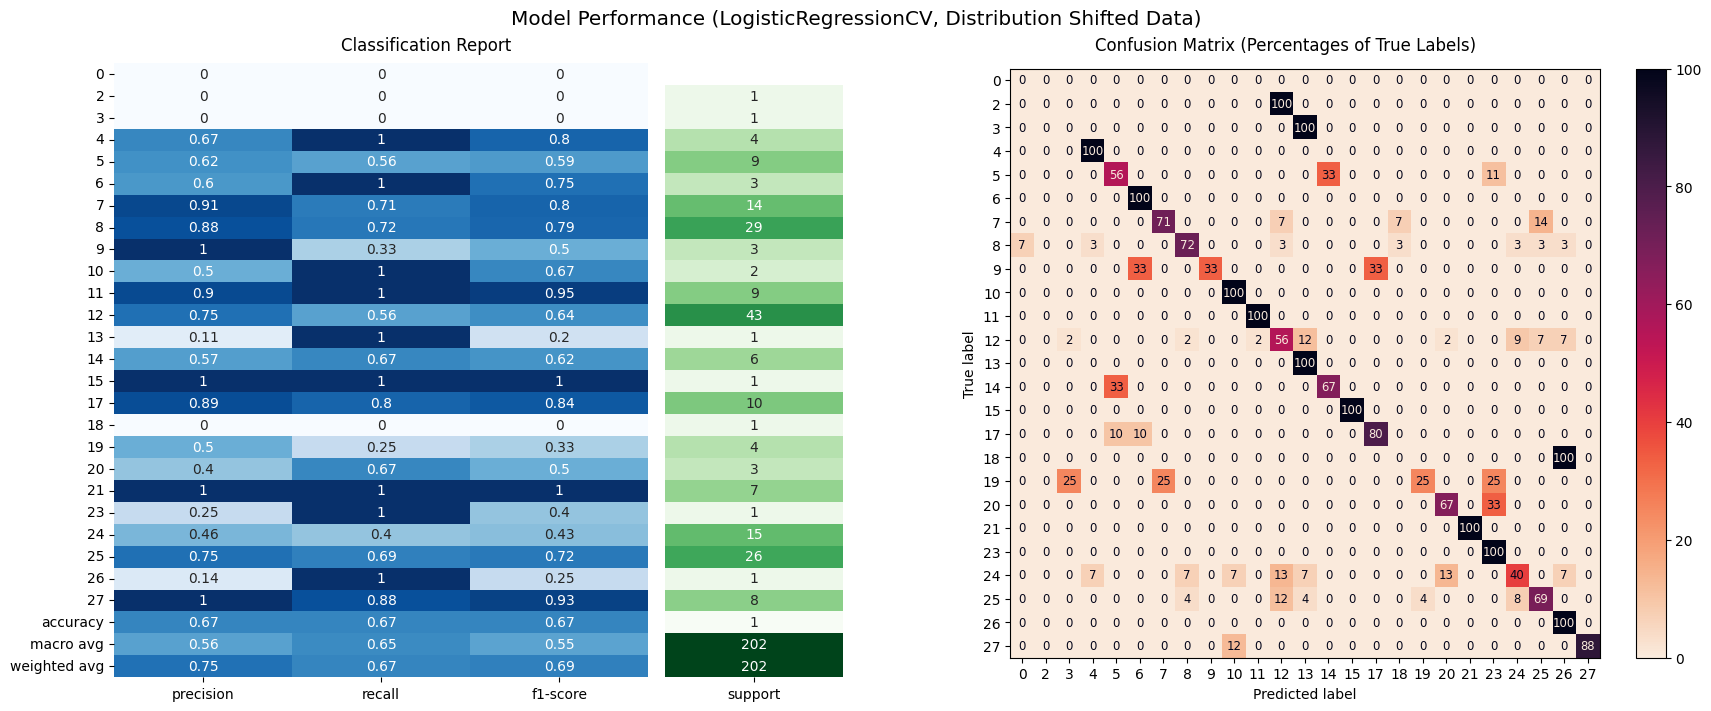

In [ ]:
# Predict on the labelled portion of test set 2 (post-distribution shift)
y_pred_shifted = lr_cv_pipe.predict(X_shifted_labelled)
y_proba_shifted = lr_cv_pipe.predict_proba(X_shifted_labelled)
print("Weighted log-loss on test set 2:", weighted_log_loss(y_shifted, y_proba_shifted))

plot_metrics(y_shifted, y_pred_shifted, "LogisticRegressionCV, Distribution Shifted Data")

Let the training samples be drawn from a "source" distribution $q(X, y)$ and the samples from the second test set be drawn from a "target" distribution $p(X, y).$ The drop in performance (weighted log-loss) likely indicates a shift in the distribution from which the samples were drawn -- that is, $q(X, y) \ne p(X, y)$. This makes the model's training inapplicable to the target distribution.

# Attempting covariate shift correction
Note that the joint distribution can be decomposed using Baye's rule: $q(X, y) = q(y|X)q(X) = q(X|y)q(y)$.

There are three main types of distribution shift -- cases when $q(X, y) \ne p(X, y)$:
1. Covariate shift: $q(X) \ne p(X)$ but $q(y|X) = p(y|X)$, which implies $q(y|X)q(X) \ne p(y|X)p(X)$
2. Label shift: $q(y) \ne p(y)$ but $q(X|y) = p(X|y)$, which implies $q(X|y)q(y) \ne p(X|y)p(y)$
3. Concept drift: $q(y|X) \ne p(y|X)$ but $q(X) = p(X)$, which implies $q(y|X)q(X) \ne p(y|X)p(X)$

(The case when $q(X|y) \ne p(X|y)$ but $q(Y) = p(X)$ would be "too difficult to study", according to [Chip Huyen](https://huyenchip.com/2022/02/07/data-distribution-shifts-and-monitoring.html#fn:20).)

For now, assume the first case -- covariate shift -- applies. This is common in cases where $X$ causes $y$, which is plausible given the covariates are customer comments and class labels are the department responsible for the product related to the customer's comment


Note that while we do see a change in the distribution of $y$ values, this can also be explained by a change in the distribution of covariates, $X$. Such a change would affect the joint distribution from which the $(X, y)$ pairs were sampled, even when $q(y|X) = p(y|X)$.

In [ ]:
# Train a basic logistic regression model to differentiate between the two
# distributions of covariates
mixed_X = np.concat((X, X_shifted))

# "Denote by z labels are 1 for data drawn from the target distribution, and -1
# for data drawn from the source distribution"
# Source: https://d2l.ai/chapter_linear-classification/environment-and-distribution-shift.html#covariate-shift-correction
source_Z = -np.ones(X.shape[0])
target_Z = np.ones(X_shifted.shape[0])
mixed_Z = np.concat((source_Z, target_Z))

print(mixed_X.shape)
print(mixed_Z.shape)
print(mixed_Z[:5], mixed_Z[-5:])

(12020, 300)
(12020,)
[-1. -1. -1. -1. -1.] [1. 1. 1. 1. 1.]


In [ ]:
discriminator = LogisticRegressionCV(class_weight="balanced", n_jobs=-1)
discriminator.fit(mixed_X, mixed_Z)
# TODO: weights = min(weights, c)

LogisticRegressionCV(class_weight='balanced', n_jobs=-1)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegressionCV was fitted without feature names
  warnings.warn(


<Axes: >

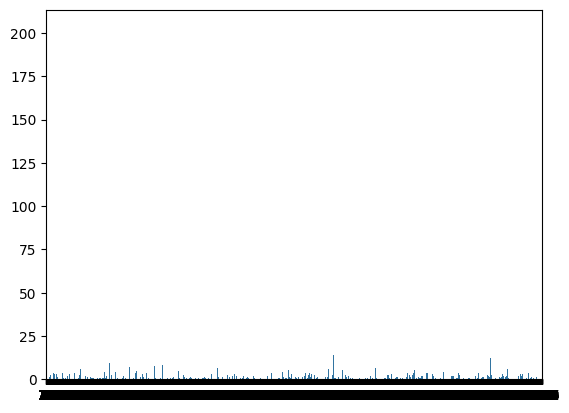

In [ ]:
# weights = exp(h(x_i)), where P(z=1|X) = 1/(1+exp(-h(X)))
cshift_sample_weight = np.exp(discriminator.decision_function(X))
sns.barplot(cshift_sample_weight)

In [ ]:
# Note that class_weight="balanced" was omitted, as that is essentially
# performing importance weighting for a uniform target distribution.
# Instead, we want to use the target distribution (X_shifted_labelled/y_shifted)
lr_cov_shift = LogisticRegressionCV(
    Cs=np.logspace(-5, 2, 10), # type: ignore
    max_iter=500,
    scoring=neg_wll,
    cv=3,
    n_jobs=-1,
).set_fit_request(sample_weight=True)

lr_cov_shift_pipe = Pipeline(steps=[
    ("scaler", scaler),
    ("classifier", lr_cov_shift),
])

lr_cov_shift_pipe.fit(X_train, y_train, sample_weight=cshift_sample_weight)
print("Best C:", np.median(lr_cov_shift_pipe.named_steps['classifier'].C_))

Best C: 0.01291549665014884


Weighted log-loss on validation set: 0.02098867550991969


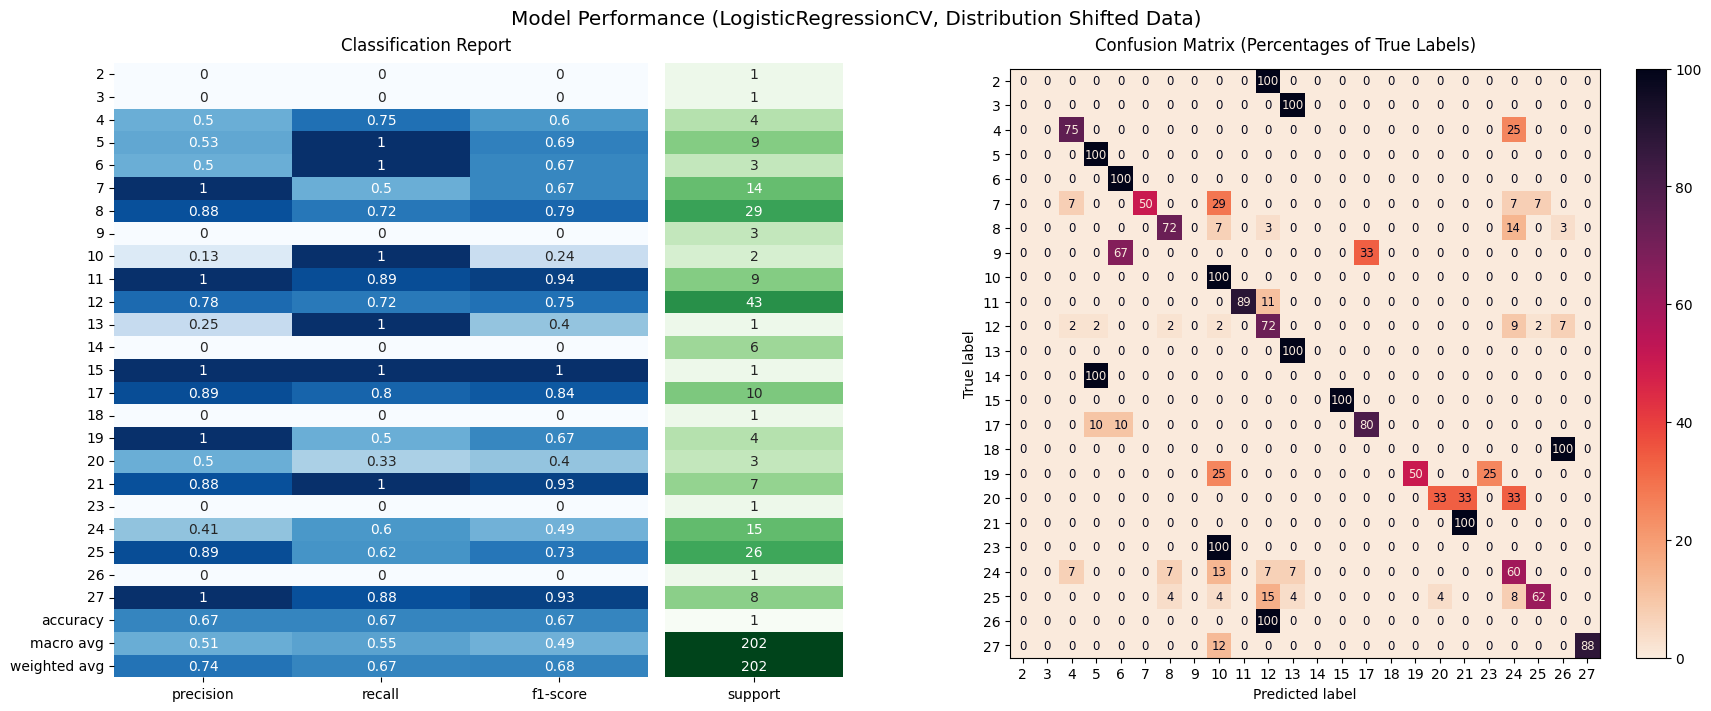

In [ ]:
# Predict on the target (shifted) distribution
y_cov_shift_pred = lr_cov_shift_pipe.predict(X_shifted_labelled)
y_cov_shift_proba = lr_cov_shift_pipe.predict_proba(X_shifted_labelled)

print("Weighted log-loss on validation set:", weighted_log_loss(y_shifted, y_cov_shift_proba))
plot_metrics(y_shifted, y_cov_shift_pred, "LogisticRegressionCV, Distribution Shifted Data")

The worsened performance could be due to a violation in the covariate shift assumption. Alternatively, it could be related to the assumption that for this correction technique to work, each data example in the target (e.g., test time) distribution had nonzero probability of occurring at training time. Perhaps the high number of features make this assumption invalid.

# Label shift correction

We can see from the histograms that the distribution of $y$ changes, so we will attempt to correct for label shift.

In [ ]:
# Adapted from https://github.com/flaviovdf/label-shift/tree/master?tab=readme-ov-file,
# which is the code
# - https://arxiv.org/pdf/1802.03916

def calculate_marginal(y, n_classes):
    """Calculate P(y)"""
    mu = np.zeros(shape=(n_classes, 1))
    for i in range(n_classes):
        mu[i] = np.sum(y == i)
    return mu / y.shape[0]

def estimate_labelshift_ratio(y_true_val, y_pred_val, y_pred_shifted, n_classes):
    """Estimate class weights for importance-weighted label shift correction,
    P_te(y)/P_tr(y). This favours classes that are more likely to appear in the
    target distribution.
    """
    labels = np.arange(n_classes)
    C = confusion_matrix(y_true_val, y_pred_val, labels=labels).T
    C = C / y_true_val.shape[0]

    mu_t = calculate_marginal(y_pred_shifted, n_classes)
    lamb = 1.0 / min(y_pred_val.shape[0], y_pred_shifted.shape[0])

    I = np.eye(n_classes)
    wt = np.linalg.solve(np.dot(C.T, C) + lamb * I, np.dot(C.T, mu_t))
    return wt.squeeze()

In [ ]:
lshift_class_weight = estimate_labelshift_ratio(y_val, y_pred_val, y_pred_shifted, N_CLASSES)
lshift_class_weight /= np.sum(lshift_class_weight)

# Weight each sample by the class weight of the corresponding true y value
lshift_sample_weight = np.sum(label_binarize(y, classes=CLASSES) * lshift_class_weight, axis=1)

In [ ]:
# Note that class_weight="balanced" was omitted, as that is essentially
# performing importance weighting for a uniform target distribution.
# Instead, we want to use the target distribution (X_shifted_labelled/y_shifted)
lr_label_shift = LogisticRegressionCV(
    Cs=np.logspace(-5, 2, 10), # type: ignore
    scoring=neg_wll,
    cv=3,
    n_jobs=-1,
).set_fit_request(sample_weight=True)

lr_label_shift_pipe = Pipeline(steps=[
    ("scaler", scaler),
    ("classifier", lr_label_shift),
])

lr_label_shift_pipe.fit(X, y, sample_weight=lshift_sample_weight)
print("Best C:", np.median(lr_label_shift_pipe.named_steps['classifier'].C_))

Best C: 0.4641588833612782


Weighted log-loss on validation set: 0.03816187990602238


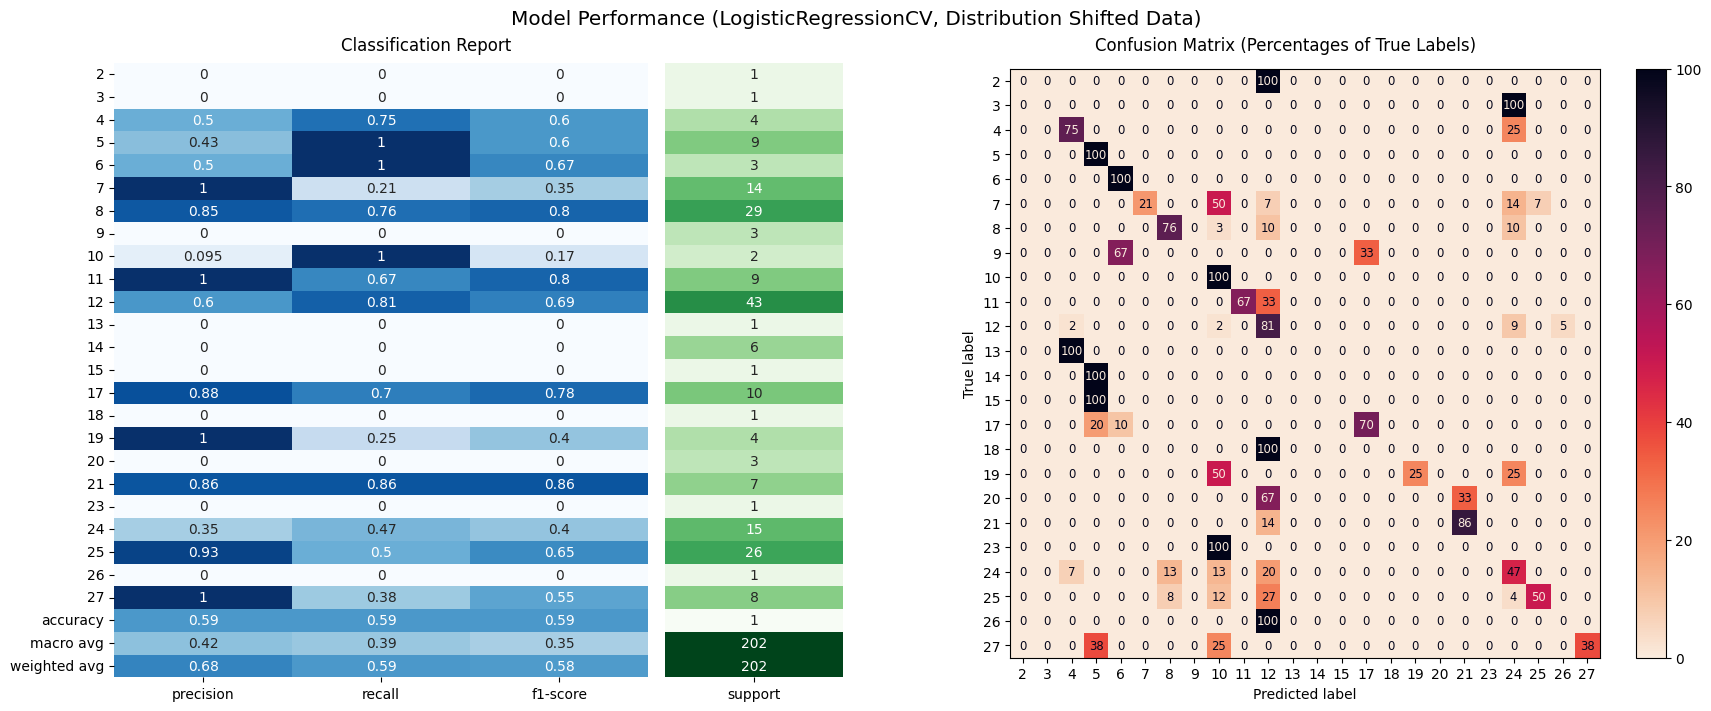

In [ ]:
# Predict on the target (shifted) distribution
y_label_shift_pred = lr_label_shift_pipe.predict(X_shifted_labelled)
y_label_shift_proba = lr_label_shift_pipe.predict_proba(X_shifted_labelled)

print("Weighted log-loss on validation set:", weighted_log_loss(y_shifted, y_label_shift_proba))
plot_metrics(y_shifted, y_label_shift_pred, "LogisticRegressionCV, Distribution Shifted Data")

## Alternate approach - directly modelling $\frac{P_{te}(y)}{P_{tr}(y)}$

Rather than estimating $\frac{P_{te}(y)}{P_{tr}(y)}$ using the confusion matrix via $Cp(y) = \mu (\hat y) \Rightarrow p(y) = C^{-1} \mu (\hat y)$, we will try to directly model $P_{te}(y)$ and $P_{tr}(y)$ by the class proportions in each dataset.

This may be a poor approximation of the true distribution ratio because of the low number of labelled samples available (202, of the 2020 samples in the shifted distribution). However, it doesn't rely on potentially inaccurate predictions of the classifier, and doesn't assume the confusion matrix is invertible.

<Axes: xlabel='class', ylabel='weight'>

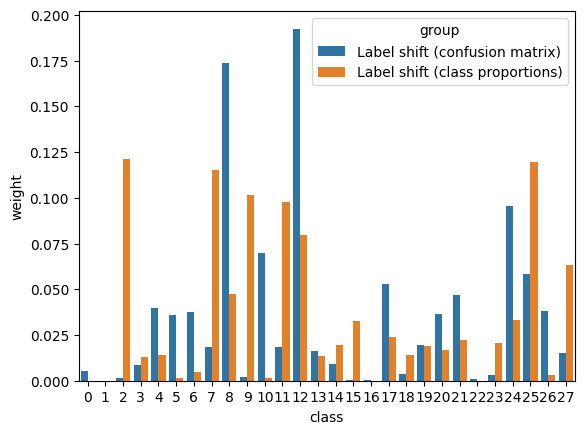

In [ ]:
p_tr = calculate_marginal(y, N_CLASSES).squeeze()
p_te = calculate_marginal(y_shifted, N_CLASSES).squeeze()

lshift_class_weight2 = p_te / p_tr
lshift_class_weight2 /= sum(lshift_class_weight2)

labels_df = pd.DataFrame({
    "class": np.tile(CLASSES, 2),
    "weight": np.concatenate((lshift_class_weight, lshift_class_weight2)),
    "group": (["Label shift (confusion matrix)"] * N_CLASSES +
        ["Label shift (class proportions)"] * N_CLASSES)
})

sns.barplot(data=labels_df, x="class", y="weight", hue="group")

In [ ]:
# Clip the values in an attempt to avoid over-predicting the majority class, 12
# lshift_class_weight2 = np.clip(lshift_class_weight2, a_min=None, a_max=0.07)
# labels_df = pd.DataFrame({
#     "class": np.tile(CLASSES, 2),
#     "weight": np.concatenate((lshift_class_weight, lshift_class_weight2)),
#     "group": (["Label shift (confusion matrix)"] * N_CLASSES +
#         ["Label shift (class proportions)"] * N_CLASSES)
# })

# sns.barplot(data=labels_df, x="class", y="weight", hue="group")

In [ ]:
lshift_sample_weight2 = np.sum(label_binarize(y, classes=CLASSES) * lshift_class_weight2, axis=1)

lr_label_shift_pipe2 = Pipeline(steps=[
    ("scaler", scaler),
    ("classifier", lr_label_shift),
])

lr_label_shift_pipe2.fit(X, y, sample_weight=lshift_sample_weight2)
print("Best C:", np.median(lr_label_shift_pipe2.named_steps['classifier'].C_))

Best C: 0.4641588833612782


Weighted log-loss on validation set: 0.02050856629529031


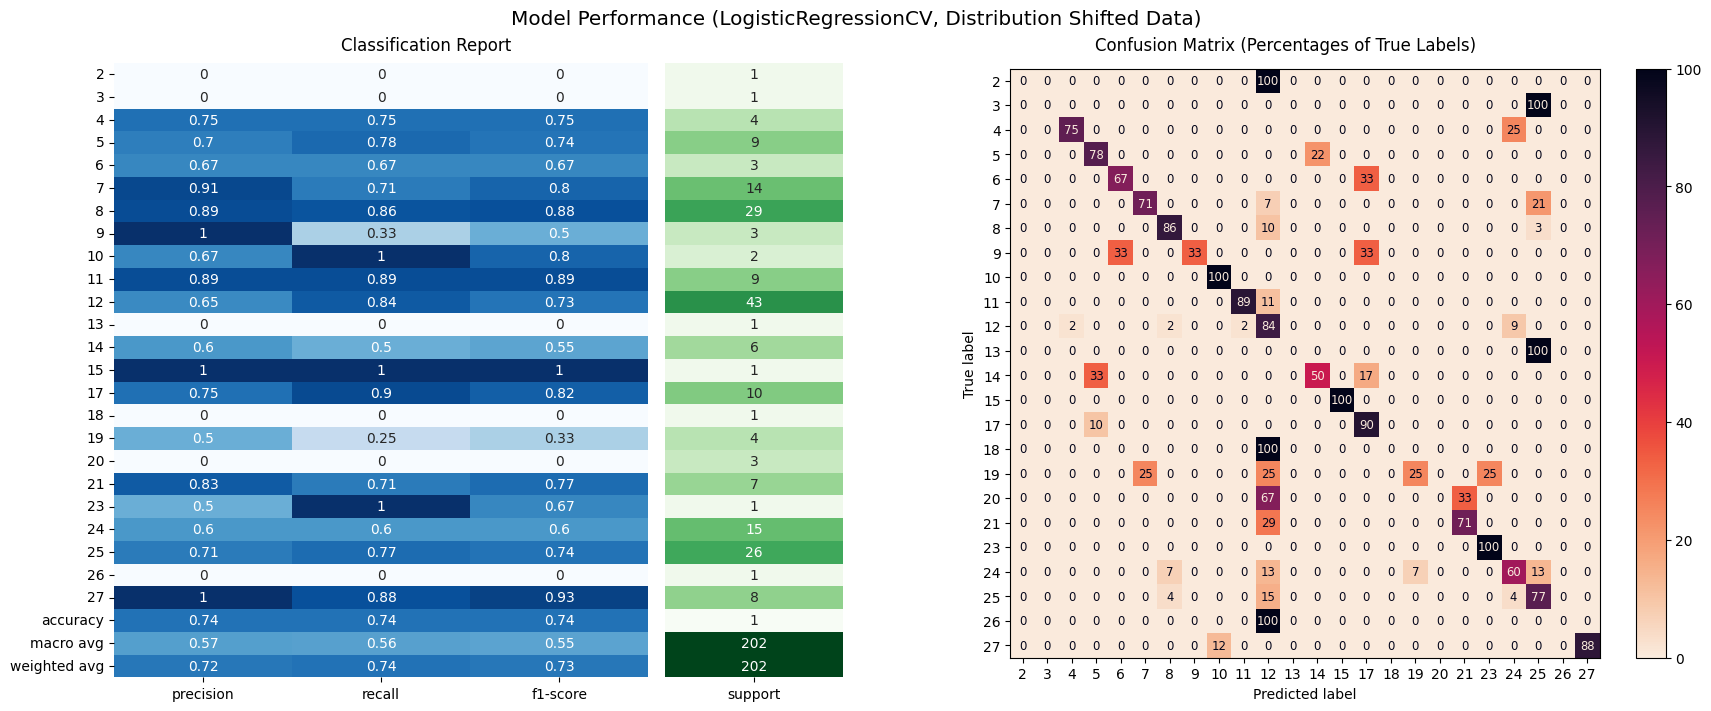

In [ ]:
# Predict on the target (shifted) distribution
y_label_shift_pred2 = lr_label_shift_pipe2.predict(X_shifted_labelled)
y_label_shift_proba2 = lr_label_shift_pipe2.predict_proba(X_shifted_labelled)

print("Weighted log-loss on validation set:", weighted_log_loss(y_shifted, y_label_shift_proba2))
plot_metrics(y_shifted, y_label_shift_pred2, "LogisticRegressionCV, Distribution Shifted Data")

This approach worked better than the previous, however there is still an issue with the model heavily favouring the majority class.

The poor performance of both of these techniques indicate the label shift assumptions (that $P(y)$ changed but $P(X|y)$ is constant) was invalid.

## Combining both approaches

Another approach could be to multiply the covariate shift weights by the label shift weights, in case both are happening simultaneously.

In [ ]:
# combined_sample_weight = cshift_class_weight * lshift_class_weight
# combined_sample_weight2 = cshift_class_weight * lshift_class_weight2

# lr_combined_shift = LogisticRegressionCV(
#     Cs=np.logspace(-5, 2, 10), # type: ignore
#     scoring=neg_wll,
#     cv=3,
#     n_jobs=-1,
# ).set_fit_request(sample_weight=True)

# lr_combined_shift_pipe = Pipeline(steps=[
#     ("scaler", scaler),
#     ("classifier", lr_combined_shift),
# ])

# lr_label_shift_pipe2.fit(X_train, y_train, sample_weight=lshift_sample_weight2)
# print("Best C:", np.median(lr_label_shift_pipe2.named_steps['classifier'].C_))

## Balanced weighting based on the test2 distribution

Recall that in the "standard" weighted log-loss formula, the class weights are defined as $w_{y_i} = \frac{1}{f_{y_i}}$, where $f_{y_i}$ is the frequency of class $y_i$ in the test set. This helps mitigate class imbalance issues. We will try to use the frequencies from the shifted distribution instead, assuming the 202 labelled samples are representative. Another approach could be to use the confusion matrix to model $P_{\text{Te}}(y)$ as seen earlier.

<Axes: >

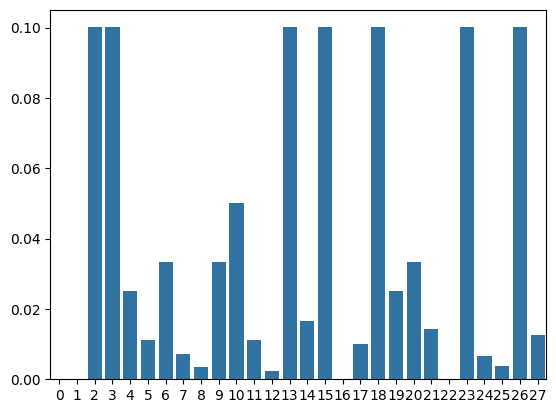

In [ ]:
# Weight the classes by the inverse frequencies
shifted_class_counts = np.sum(label_binarize(y_shifted, classes=CLASSES), axis=0)
# Note that we could've instead modelled P(y_Te) using
#   calculate_marginal(y_shifted, N_CLASSES).squeeze()
# which is just f_{y_Te} scaled by a constant factor

# class_weights = 1/class_counts, weighting classes with no samples as 0
#   https://stackoverflow.com/a/37977222/21453336
balanced_shifted_class_weight = np.divide(
    1.0,
    shifted_class_counts,
    out=np.zeros(shifted_class_counts.shape, dtype=float),
    where=shifted_class_counts!=0
)

# Normalise the weights so they sum to 1 (for interpretability)
balanced_shifted_class_weight /= np.sum(balanced_shifted_class_weight)

# Weight each sample by the class weight of the corresponding true y value
balanced_shifted_sample_weight = np.sum(
    label_binarize(y, classes=CLASSES) * balanced_shifted_class_weight,
    axis=1
)

# Sanity check of class weights
sns.barplot(balanced_shifted_class_weight)

In [ ]:
lr_shift_balanced_pipe = Pipeline(steps=[
    ("scaler", scaler),
    ("classifier", lr_label_shift),
])

lr_shift_balanced_pipe.fit(X, y, sample_weight=balanced_shifted_sample_weight)
print("Best C:", np.median(lr_shift_balanced_pipe.named_steps['classifier'].C_))

Best C: 0.4641588833612782


Weighted log-loss on validation set: 0.020686329836161588


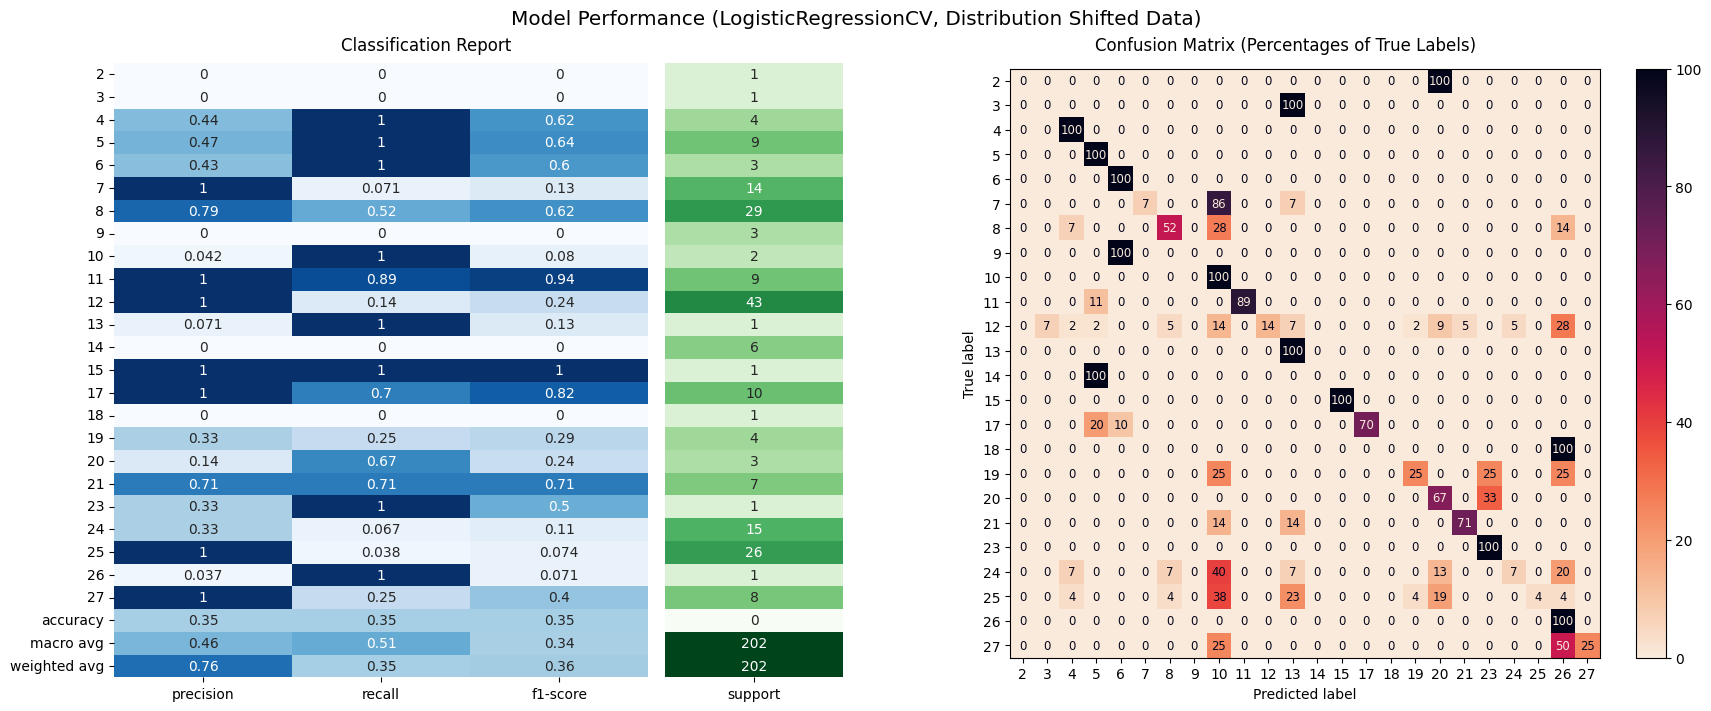

In [ ]:
# Predict on the target (shifted) distribution
y_shift_balanced_pred = lr_shift_balanced_pipe.predict(X_shifted_labelled)
y_shift_balanced_proba = lr_shift_balanced_pipe.predict_proba(X_shifted_labelled)

print("Weighted log-loss on validation set:", weighted_log_loss(y_shifted, y_shift_balanced_proba))
plot_metrics(y_shifted, y_shift_balanced_pred, "LogisticRegressionCV, Distribution Shifted Data")

## Chaining the weights to correct the class imbalance of the target distribution
Try using the importance-weighted, label-weighted log loss. This is in the hopes of minimising the expected weighted log loss under the target distribution.

In [ ]:
wt = cshift_sample_weight * balanced_shifted_sample_weight
pipe = Pipeline(steps=[
    ("scaler", scaler),
    ("classifier", lr_label_shift),
])

pipe.fit(X, y, sample_weight=wt)
print("Best C:", np.median(pipe.named_steps['classifier'].C_))

Best C: 0.4641588833612782


Weighted log-loss on validation set: 0.020859697787825288


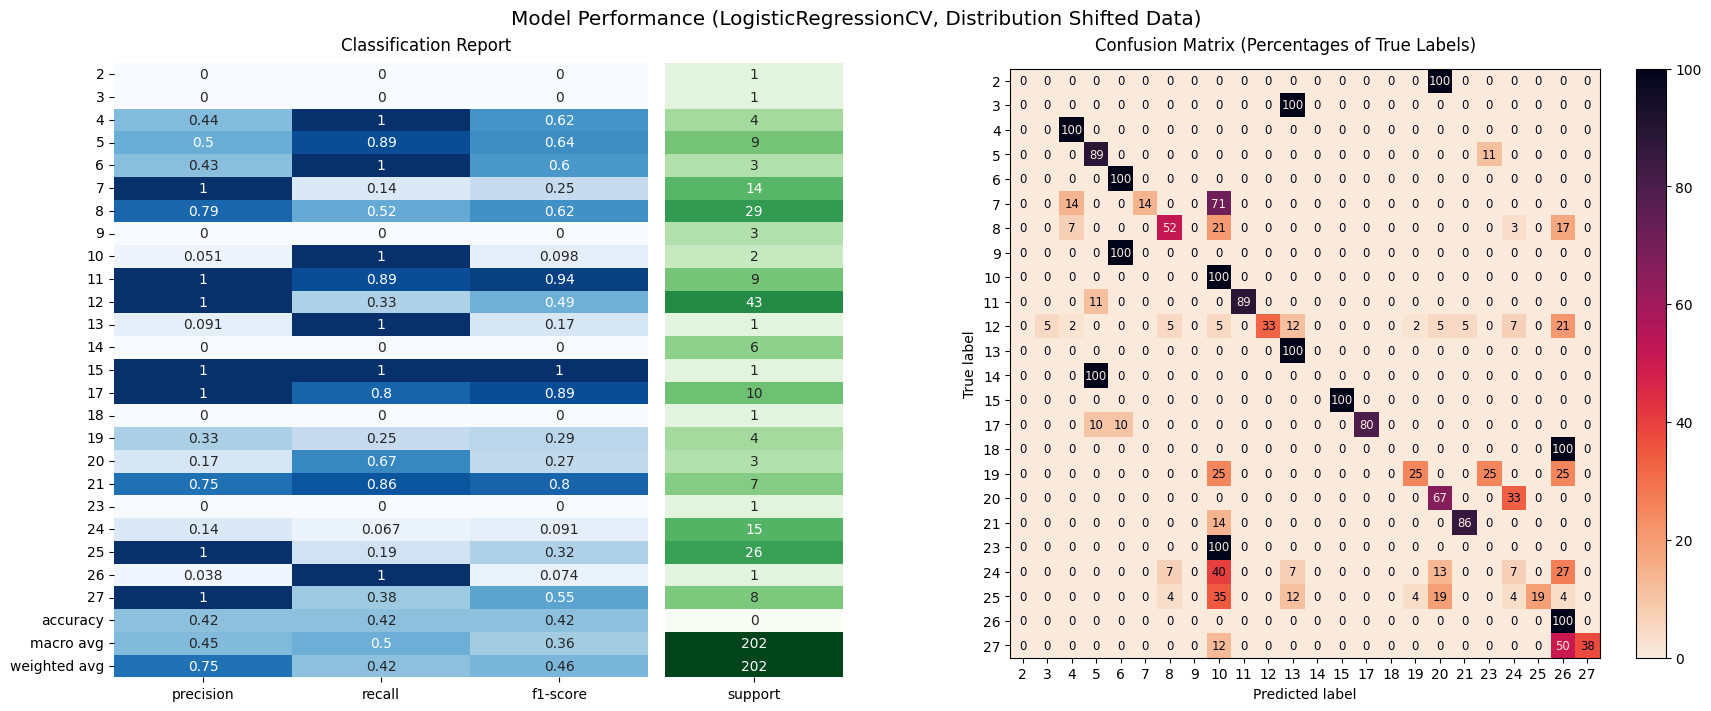

In [ ]:
# Predict on the target (shifted) distribution
pred = pipe.predict(X_shifted_labelled)
proba = pipe.predict_proba(X_shifted_labelled)

print("Weighted log-loss on validation set:", weighted_log_loss(y_shifted, proba))
plot_metrics(y_shifted, pred, "LogisticRegressionCV, Distribution Shifted Data")

In [ ]:
wt = lshift_sample_weight * balanced_shifted_sample_weight
pipe = Pipeline(steps=[
    ("scaler", scaler),
    ("classifier", lr_label_shift),
])

pipe.fit(X, y, sample_weight=wt)
print("Best C:", np.median(pipe.named_steps['classifier'].C_))

Best C: 16.68100537200059


Weighted log-loss on validation set: 0.03218543519646297


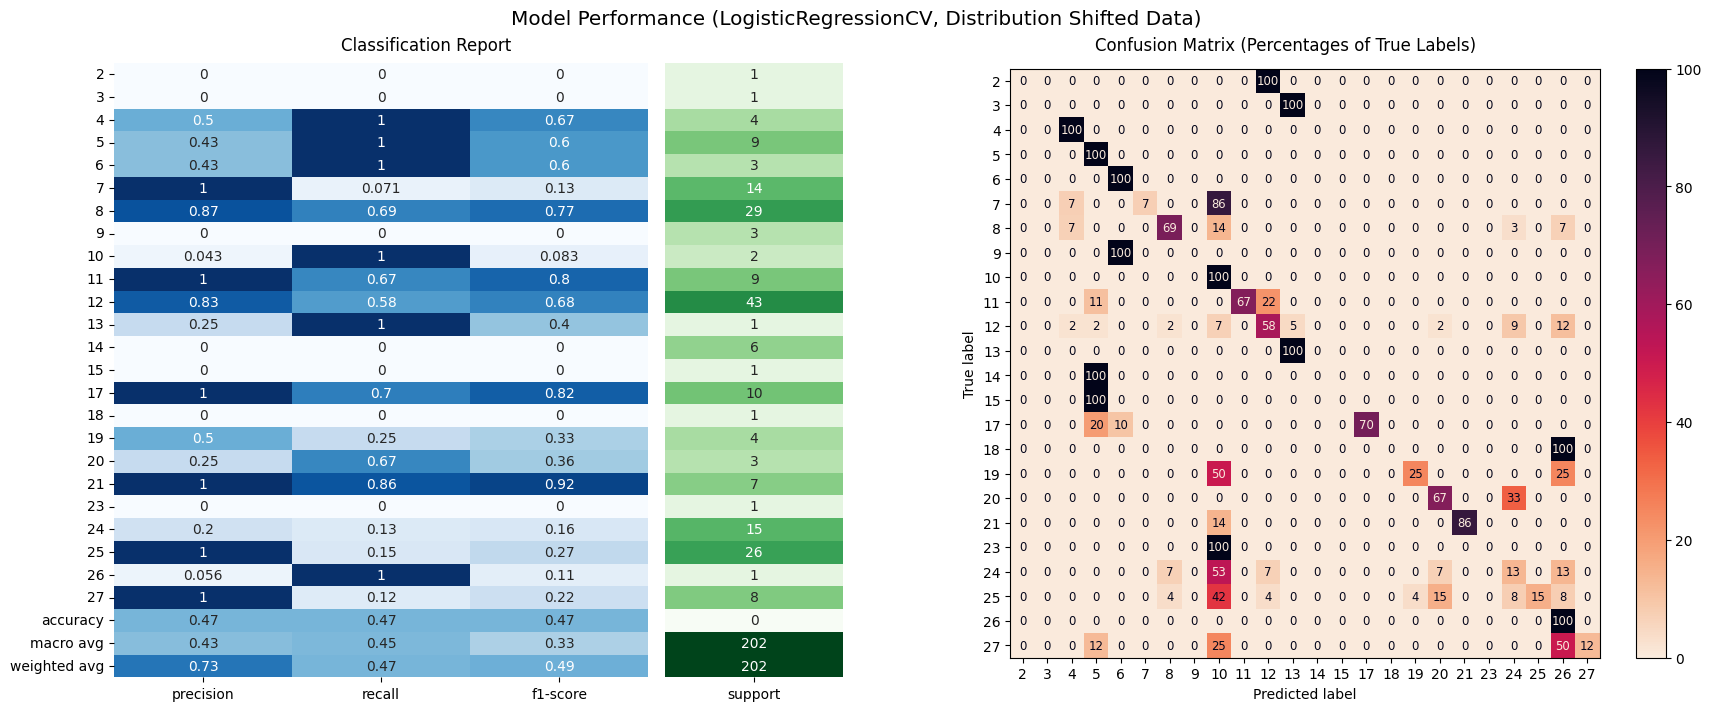

In [ ]:
# Predict on the target (shifted) distribution
pred = pipe.predict(X_shifted_labelled)
proba = pipe.predict_proba(X_shifted_labelled)

print("Weighted log-loss on validation set:", weighted_log_loss(y_shifted, proba))
plot_metrics(y_shifted, pred, "LogisticRegressionCV, Distribution Shifted Data")

In [ ]:
wt = lshift_sample_weight2 * balanced_shifted_sample_weight
pipe = Pipeline(steps=[
    ("scaler", scaler),
    ("classifier", lr_label_shift),
])

pipe.fit(X, y, sample_weight=wt)
print("Best C:", np.median(pipe.named_steps['classifier'].C_))

Best C: 16.68100537200059


Weighted log-loss on shifted dataset: 0.015672572235521848


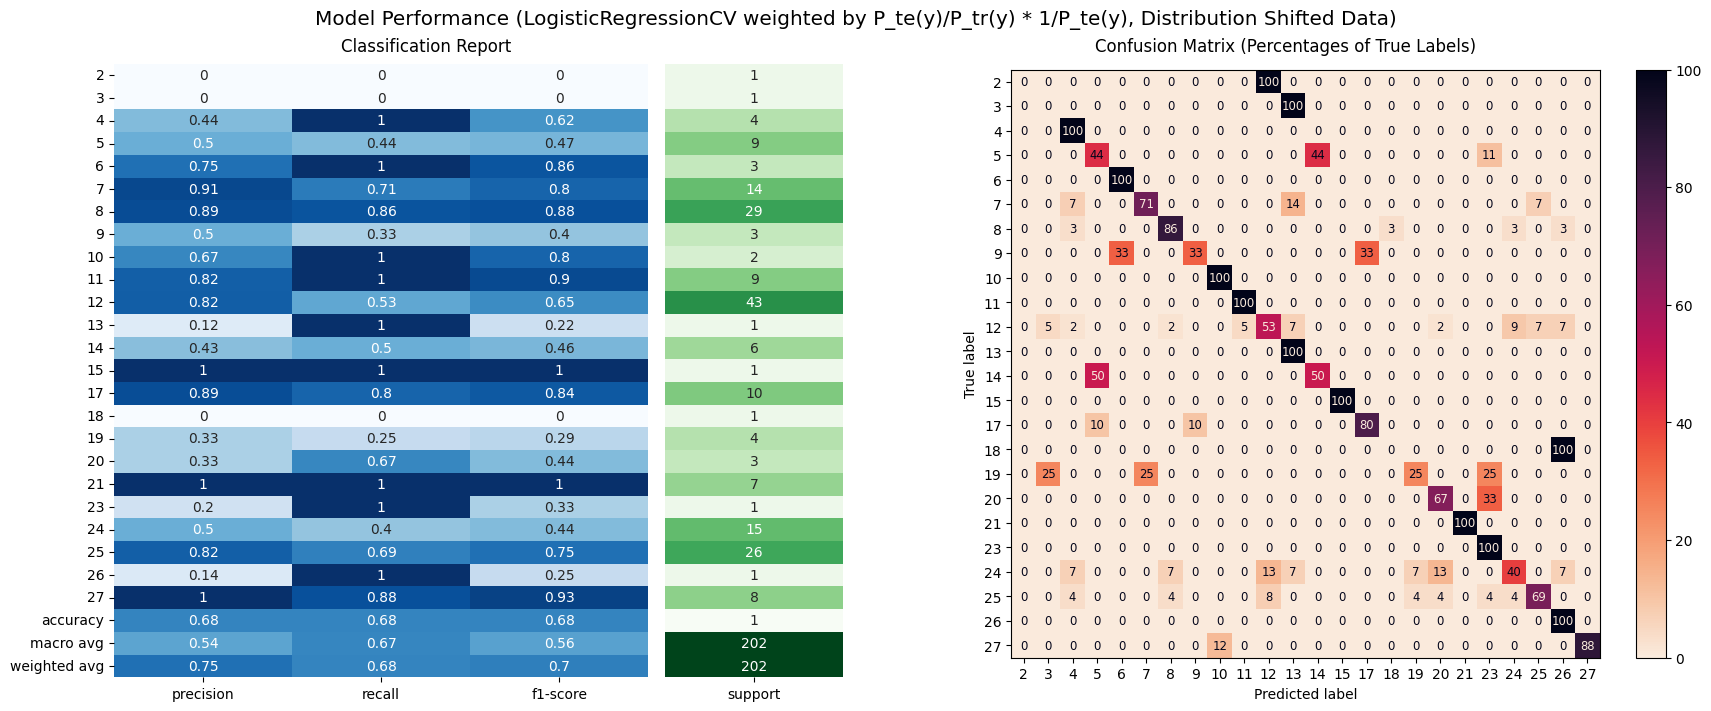

In [ ]:
# Predict on the target (shifted) distribution
pred = pipe.predict(X_shifted_labelled)
proba = pipe.predict_proba(X_shifted_labelled)

print("Weighted log-loss on shifted dataset:", weighted_log_loss(y_shifted, proba))
plot_metrics(y_shifted, pred, "LogisticRegressionCV weighted by P_te(y)/P_tr(y) * 1/P_te(y), Distribution Shifted Data")